In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!pip install catboost
import pandas as pd
import numpy as np
import os
import seaborn as sns 
from scipy import stats
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import xgboost as xgb
import catboost as catb
import operator
import time
import ast
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")


In [0]:
import pandas as pd
#https://drive.google.com/open?id=1bOQiIBne8aPCg6hLKeiHLTklS2mnWdII
#https://drive.google.com/open?id=1Gb6aE1lJn3jukR0_DKfhwjj-AnP9c6XS
tr1_id = '1bOQiIBne8aPCg6hLKeiHLTklS2mnWdII'
tr2_id = '1Gb6aE1lJn3jukR0_DKfhwjj-AnP9c6XS'

down1 = drive.CreateFile({'id':tr1_id})
down2 = drive.CreateFile({'id':tr2_id})

down1.GetContentFile('train.csv')
down2.GetContentFile('test.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

train.head()

(3000, 23)
(4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [0]:
print(str(train.shape) + ' | ' + str(test.shape))

(3000, 23) | (4398, 22)


In [0]:
m_train, n1 = train.shape
m_test, n2 = test.shape
print("{} training samples".format(m_train))
print("{} test samples".format(m_test))
print("{} features for train samples".format(n1))
print("{} features for test samples".format(n2))

3000 training samples
4398 test samples
23 features for train samples
22 features for test samples


### Basic Visuals for Data Types and Null Values

Text(0.5, 1.0, 'Count Columns By Datatypes for test data')

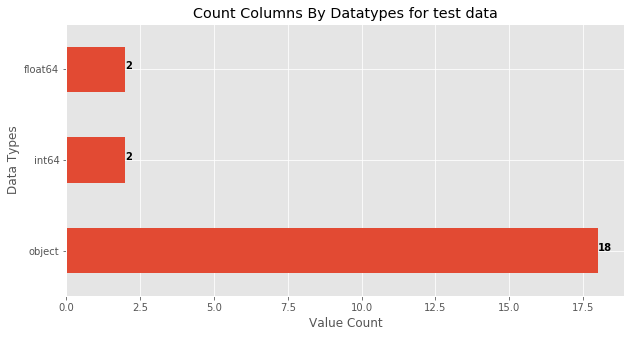

In [0]:
test.dtypes.value_counts().plot(kind="barh", figsize=(10,5))
for i, v in enumerate(test.dtypes.value_counts()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 10)
plt.xlabel("Value Count")
plt.ylabel("Data Types")
plt.title("Count Columns By Datatypes for test data")

Text(0.5, 1.0, 'Count Columns By Datatypes for Train data')

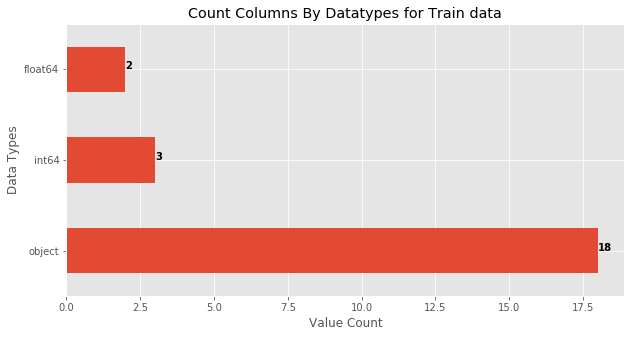

In [0]:
train.dtypes.value_counts().plot(kind="barh", figsize=(10,5))
for i, v in enumerate(train.dtypes.value_counts()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 10)
plt.xlabel("Value Count")
plt.ylabel("Data Types")
plt.title("Count Columns By Datatypes for Train data")

Text(0.5, 1.0, 'Missing Value count By Features for Test data')

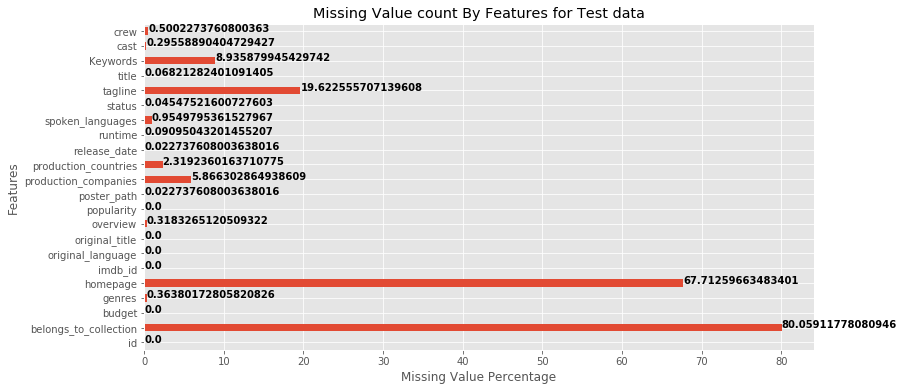

In [0]:
((test.isna().sum()/test.shape[0])*100).plot(kind="barh", figsize=(12,6))
for i, v in enumerate((test.isna().sum()/test.shape[0])*100):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 10)
plt.xlabel("Missing Value Percentage")
plt.ylabel("Features")
plt.title("Missing Value count By Features for Test data")


Text(0.5, 1.0, 'Missing Value count By Features for train data')

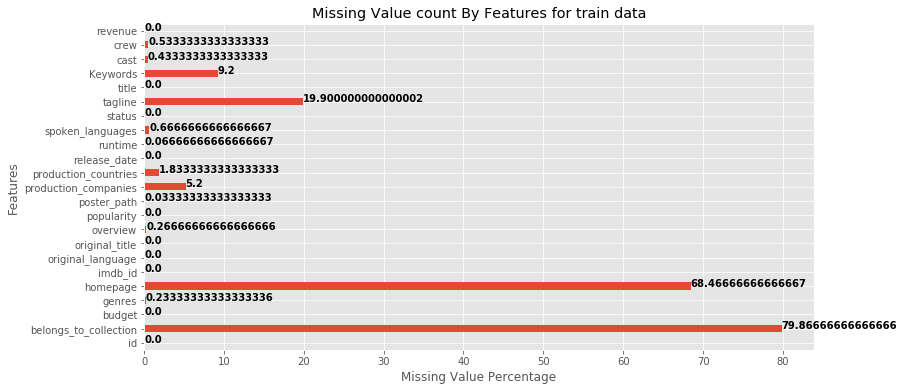

In [0]:
((train.isna().sum()/train.shape[0])*100).plot(kind="barh", figsize=(12,6))
for i, v in enumerate((train.isna().sum()/train.shape[0])*100):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 10)
plt.xlabel("Missing Value Percentage")
plt.ylabel("Features")
plt.title("Missing Value count By Features for train data")


### Insights from the statistics

In [0]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


**Some Insight from Statistics**

1. We should filter out non-sense revenue values: look at min=1.0
2. We should filter out non-sense runtime values: look at min=0.0
3. We should inspect why there are that many budget=0: look at min=25%=0.0
4. We should understand the meaning the 'popularity' to deal with it: look at max=294.3 vs 75%=10.9

In [0]:
train.describe(include="all")

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0120667,en,Alone in the Dark,Zohre's shoes are gone; her older brother Ali ...,NaN,/a5DZoqNJ8O1Az0TMJFMyxo8PqyJ.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Hercules,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5601b965c3a3685625002173', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


###All Features insight from Statistics
1. Be careful with > 'original title': 25 are repeated, 'title': 31 repeated
2. 86% of movies in English
3. 'status' only have two values. 99.8% are Released
4. To be dropped for sure (4/23): 'homepage' (may be useful to get external data), 'tmdb_id' (may be useful to get external data), 'original_title' (as we have English title), 'poster_path' (useless).


### Drop unwanted columns

In [0]:
# Delete unused columns
train.drop(columns=['imdb_id', 'poster_path'], inplace=True)
test.drop(columns=['imdb_id', 'poster_path'], inplace=True)

# Cast budget and revenue to float
train.budget = train.budget.astype(float)
train.revenue = train.revenue.astype(float)
test.budget = test.budget.astype(float)

### Important Feature Analysis (**Budget** against **Revenue**)

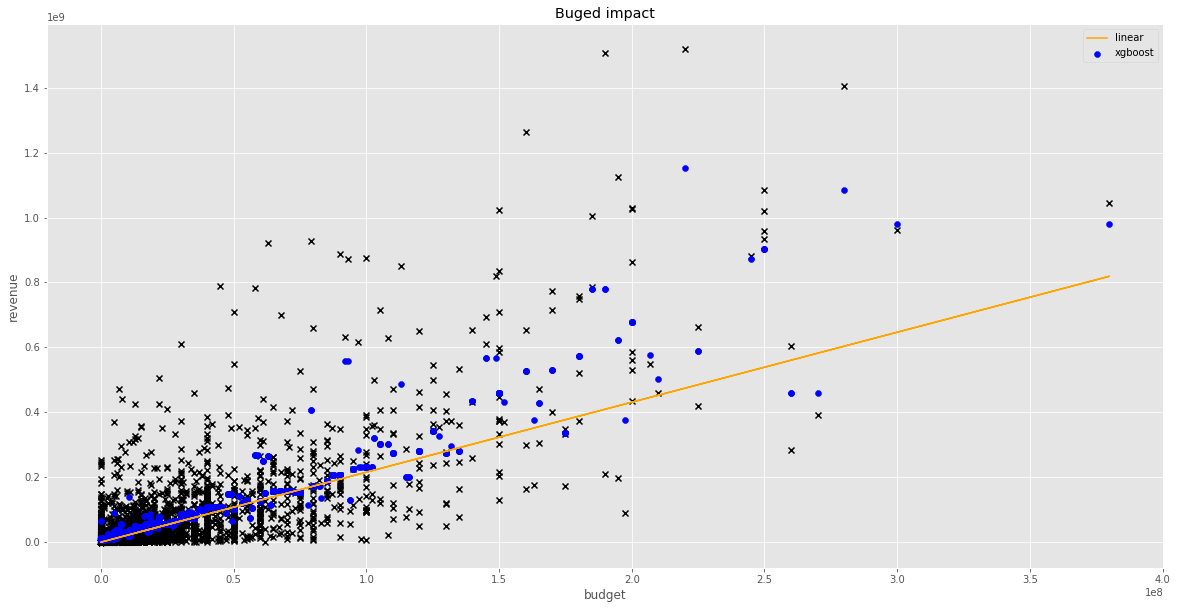

In [0]:
# We plot the scatter of the budget / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = train['budget'], y = train['revenue'], marker = 'x', color = 'black')

# We fit a linear model
from sklearn import linear_model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train['budget']).reshape(-1,1), y = train['revenue'])
rev_pred = model.predict(np.array(train['budget']).reshape(-1,1))

# We plot the fit 
plt.plot(train['budget'], rev_pred, color = 'orange', label = 'linear')

# We fit an xgboost model 
import xgboost as xg
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(np.array(train['budget']).reshape(-1,1), np.array(train['revenue']))
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(np.array(train['budget']).reshape(-1,1))
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(train['budget'], rev_pred, color = 'blue', label = 'xgboost')

plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Buged impact')
plt.legend()
plt.show()


### Important Fature Analysis (**Popularity** against **Revenue**)

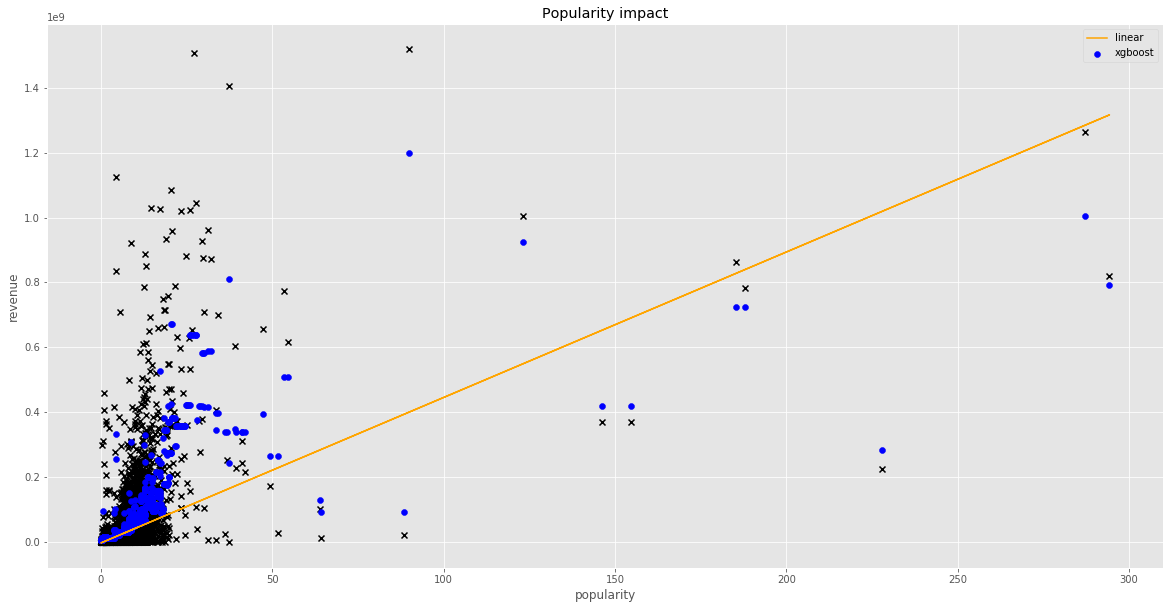

In [0]:
# We plot the scatter of the popularity / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = train['popularity'], y = train['revenue'], marker = 'x', color = 'black')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train['popularity']).reshape(-1,1), y = train['revenue'])
rev_pred = model.predict(np.array(train['popularity']).reshape(-1,1))

# We plot the fit 
plt.plot(train['popularity'], rev_pred, color = 'orange', label = 'linear')


# We fit an xgboost model 
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(np.array(train['popularity']).reshape(-1,1), np.array(train['revenue']))
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(np.array(train['popularity']).reshape(-1,1))
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(train['popularity'], rev_pred, color = 'blue', label = 'xgboost')


plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title('Popularity impact')
plt.legend()
plt.show()


### Important Fature Analysis (**Runtime** against **Revenue**)

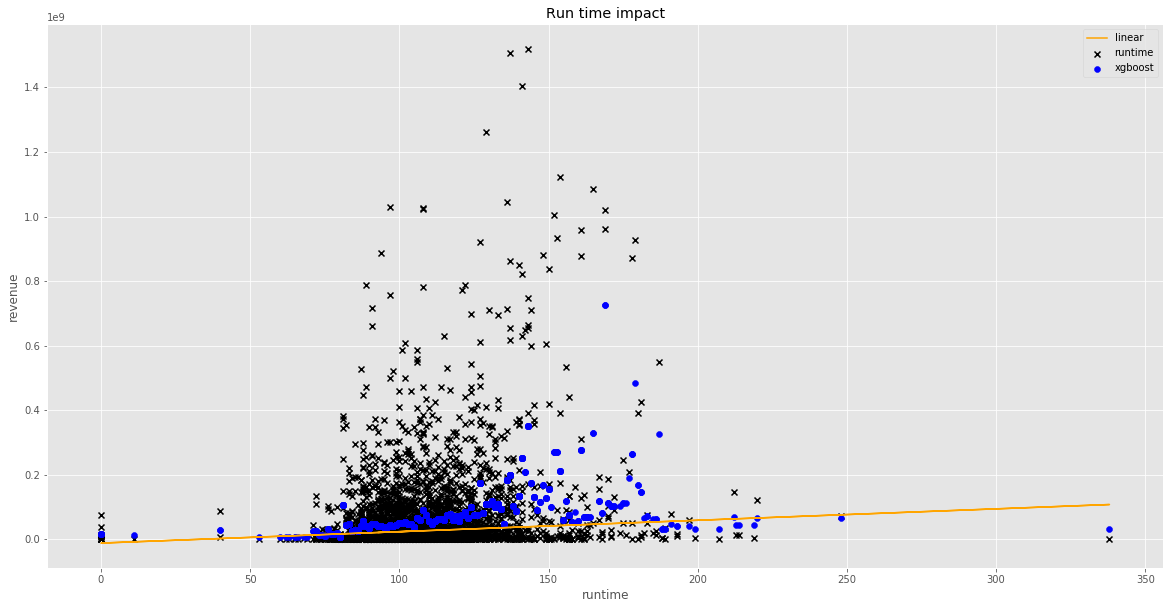

In [0]:
idxs = np.where(train['runtime'].isna() == False)[0]
runtime = np.array(train['runtime'][idxs]).reshape(-1,1)
revenue = np.array(train['revenue'][idxs])

# We plot the scatter of the budget / revenue
plt.figure(figsize=(20,10))
plt.scatter(x = runtime, y = revenue, marker = 'x', color = 'black', label = 'runtime')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = runtime, y = revenue)
rev_pred = model.predict(runtime)

# We plot the fit 
plt.plot(runtime, rev_pred, color = 'orange', label = 'linear')


# We fit an xgboost model 
params = {'eval_metric' : 'rmse', 'silent' : 1}
dtrain = xg.DMatrix(runtime, revenue)
xg_model = xg.train(params, dtrain)
dtest = xg.DMatrix(runtime)
rev_pred = xg_model.predict(dtest)

# We plot the fit 
plt.scatter(runtime, rev_pred, color = 'blue', label = 'xgboost')


plt.xlabel('runtime')
plt.ylabel('revenue')
plt.title('Run time impact')
plt.legend()
plt.show()


### Deal with NaN

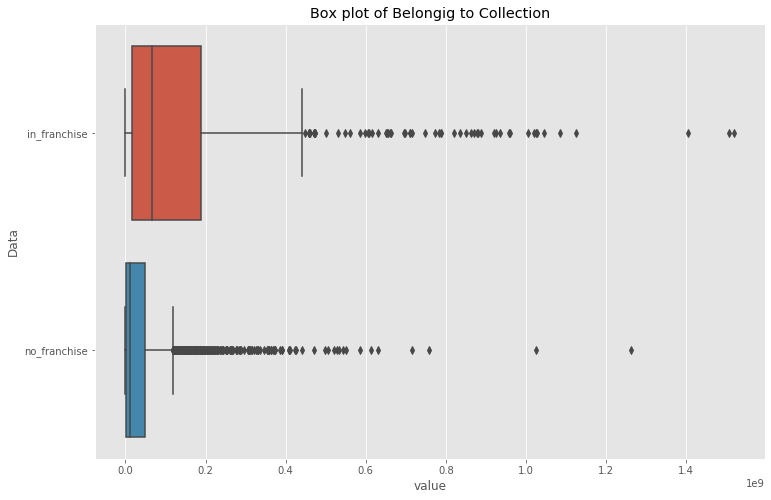

In [0]:
# "belongs_to_collection": Clean, EDA and create bool > True if belongs to a saga(franchise), False if not
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange','medians': 'DarkBlue', 'caps': 'Gray'}
plt.figure(figsize=(12,8))
belongs_df = train[['belongs_to_collection', 'revenue']]
belongs_df['belongs_to_collection_bool'] = True
belongs_df.belongs_to_collection_bool[train.belongs_to_collection.isnull()] = False
belongs_df['in_franchise'] = np.nan
belongs_df.in_franchise[belongs_df.belongs_to_collection_bool == True] = belongs_df.revenue[belongs_df.belongs_to_collection_bool == True] 
belongs_df['no_franchise'] = np.nan
belongs_df.no_franchise[belongs_df.belongs_to_collection_bool == False] = belongs_df.revenue[belongs_df.belongs_to_collection_bool == False] 
belongs_df.belongs_to_collection[~train.belongs_to_collection.isnull()] = train.belongs_to_collection[~train.belongs_to_collection.isnull()].str.split("'name': '").str[1].str.split("', 'poster").str[0]
belongs_df.drop(columns=['revenue', 'belongs_to_collection', 'belongs_to_collection_bool'], inplace=True)
#print("Movies in Franchise: {}/{}={}% ".format(len(~belongs_df.in_franchise.isnull()), len(belongs_df), 100.0*len(~belongs_df.in_franchise.isnull())/len(belongs_df)))
# belongs_boxplot = belongs_df.boxplot(figsize=(15, 10), rot=90)
sns.boxplot(data=belongs_df, orient='h')
plt.xlabel('value')
plt.ylabel('Data')
plt.title('Box plot of Belongig to Collection')
plt.show()


In [0]:
belongs_df = train[['belongs_to_collection', 'revenue']]
belongs_df['belongs_to_collection_bool'] = True
belongs_df.belongs_to_collection_bool[train.belongs_to_collection.isnull()] = False
belongs_df.head()
features = belongs_df['belongs_to_collection_bool']
features.value_counts()

False    2396
True      604
Name: belongs_to_collection_bool, dtype: int64

### Box Plots for Genres

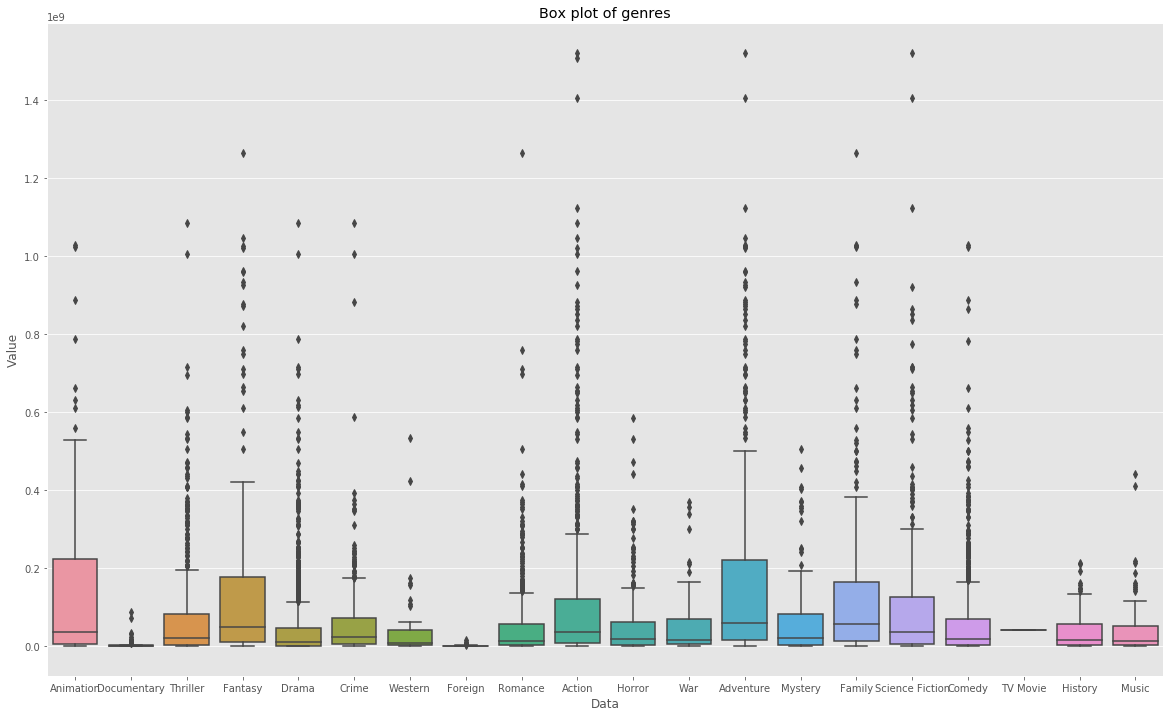

In [0]:
# "genres": Clean, EDA and create bools > True if belongs to a specific genre, False if not
genres_df = train[['genres', 'revenue']]
genres_df['genres_test'] = genres_df['genres']
genres_df.head()
genres_df.genres_test = genres_df.genres_test.str.strip('[]')
genres_df.genres_test[genres_df.genres_test.isnull()] = ''
genres_list = pd.Series(list(set(", ".join(genres_df.genres_test.unique().tolist()).split('}, ')))).str.split("'name': '").str[1].str.split("'").str[0].tolist()
#genres_list
for i, genre in enumerate(genres_list):
    genres_df[genre] = np.nan
    genres_df[genre][genres_df.genres_test.str.contains(genre)] = genres_df.revenue[genres_df.genres_test.str.contains(genre)]
genres_df.drop(columns=['revenue', 'genres', 'genres_test'], inplace=True)
genres_df.head()
# genres_boxplot = genres_df.boxplot(figsize=(15, 10), rot=90)
plt.figure(figsize=(20,12))
sns.boxplot(data=genres_df)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Box plot of genres')
plt.show()



## Revenue

No handles with labels found to put in legend.


125


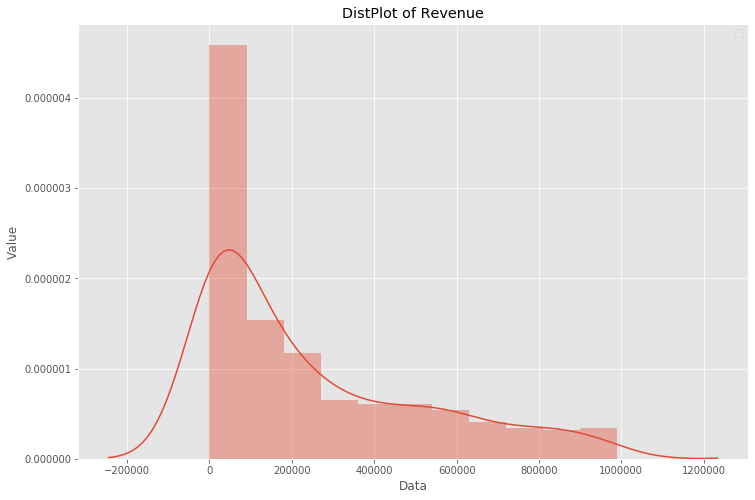

In [0]:
revenue_df = train[['title', 'revenue']].sort_values('revenue')
print(len(revenue_df[revenue_df.revenue<2e4]))
revenue_df.head()
revenue_boxplot = revenue_df[['revenue']][revenue_df.revenue < 1e6]
plt.figure(figsize=(12,8))
sns.distplot(revenue_boxplot)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('DistPlot of Revenue')
plt.legend()
plt.show()


## Budget

No handles with labels found to put in legend.


849


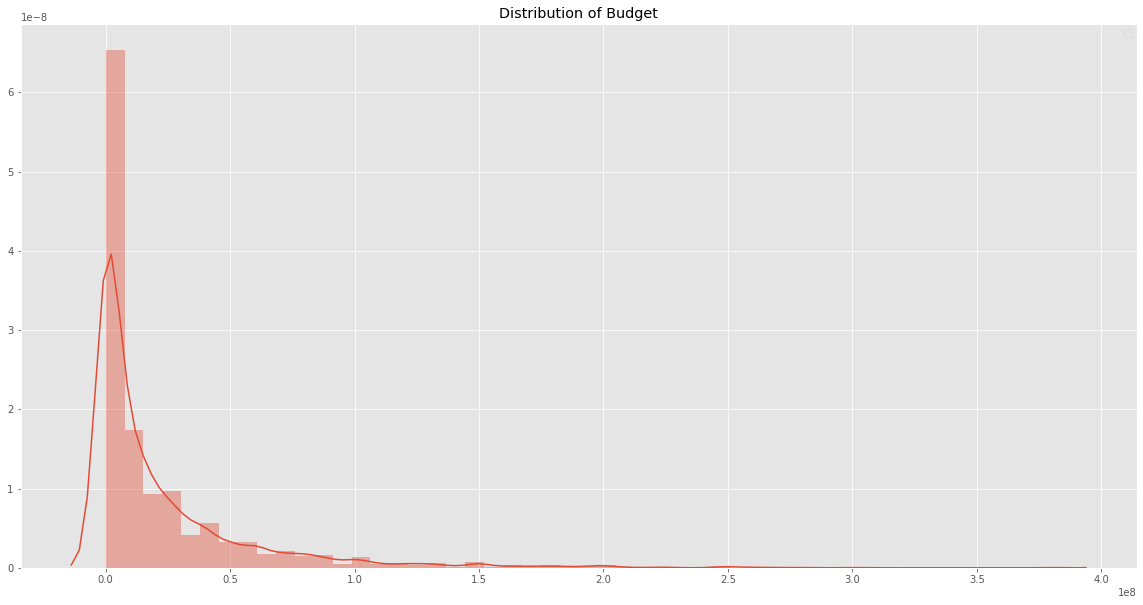

,title,budget
895,Gray Lady Down,0.0
594,Tommy Boy,0.0
595,A Prince (almost) Charming,0.0
1252,Murder in the First,0.0
2144,The Final Cut,0.0


In [0]:
budget_df = train[['title', 'budget']].sort_values('budget')
print(len(budget_df[budget_df.budget<1e5]))
budget_boxplot = budget_df[['budget']][budget_df.budget < 1e9]
plt.figure(figsize=(20,10))
sns.distplot(budget_boxplot)
plt.title('Distribution of Budget')
plt.legend()
plt.show()
budget_df.head()

Insight

Reason 1: I checked some of the movies with very low budget and it does not coincide with Google info (our data is probably wrong)

Reason 2: my experience says there's no way a movie can cost hundreds of dollars only (or less). Only with camera rental and actors' payroll that should be a couple hundreds/thousands.

Reason 3: check the amount of movies when a) budget<10K -> 835 b)budget<100K -> 849. The distribution points to an error for movies with budget<10K

## Status

In [0]:
# "status": Study the two existing values
status_df = train[['status', 'revenue']]

status_df = status_df.groupby('status', as_index=False).agg({'revenue' : ['min', 'max', 'mean', 'count']})
print("Possible status: {} ".format(status_df.status.unique().tolist()))
status_df.head()


Possible status: ['Released', 'Rumored'] 


status revenue                                  
                min           max          mean count
0  Released     1.0  1.519558e+09  6.681029e+07  2996
1   Rumored    60.0  1.341809e+07  3.480199e+06     4

#### Null count for each column

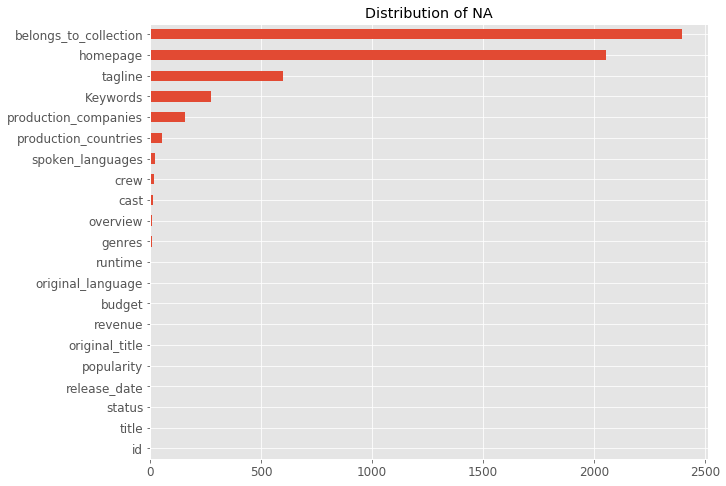

In [0]:
fig = plt.figure(figsize=(10, 8))
plt.title("Distribution of NA")
train.isna().sum().sort_values(ascending=True).plot(kind='barh', fontsize=12)

In [0]:
train.dropna().shape

(203, 21)

### Checking for Outliers

In [0]:
train[['revenue', 'budget', 'runtime']].describe()

,revenue,budget,runtime
count,3.000000e+03,3.000000e+03,2998.000000
mean,6.672585e+07,2.253133e+07,107.856571
std,1.375323e+08,3.702609e+07,22.086434
min,1.000000e+00,0.000000e+00,0.000000
25%,2.379808e+06,0.000000e+00,94.000000
50%,1.680707e+07,8.000000e+06,104.000000
75%,6.891920e+07,2.900000e+07,118.000000
max,1.519558e+09,3.800000e+08,338.000000


#### Cleaning

In [0]:
train.loc[train['id'] == 1542]

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1541,1542,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,ru,Все и сразу,NaN,0.201582,"[{'name': 'Кинокомпания «Lunapark»', 'id': 420...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",6/5/14,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,"[{'id': 642, 'name': 'robbery'}, {'id': 231149...","[{'cast_id': 3, 'character': 'Viktor', 'credit...","[{'credit_id': '53b7a7b90e0a2676b8006ab6', 'de...",3.0


In [0]:
##Train Revenue and Budget
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 3000000        # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture

In [0]:
# Test Budget
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee


In [0]:
# Test and Train Runtime

In [0]:
# TRAIN 

train.runtime[train.id == 391] = 86 #Il peor natagle de la meva vida
train.runtime[train.id == 592] = 90 #А поутру они проснулись
train.runtime[train.id == 925] = 95 #¿Quién mató a Bambi?
train.runtime[train.id == 978] = 93 #La peggior settimana della mia vita
train.runtime[train.id == 1256] = 92 #Cipolla Colt
train.runtime[train.id == 1542] = 93 #Все и сразу
train.runtime[train.id == 1875] = 86 #Vermist
train.runtime[train.id == 2151] = 108 #Mechenosets
train.runtime[train.id == 2499] = 108 #Na Igre 2. Novyy Uroven
train.runtime[train.id == 2646] = 98 #同桌的妳
train.runtime[train.id == 2786] = 111 #Revelation
train.runtime[train.id == 2866] = 96 #Tutto tutto niente niente

# TEST
test.runtime[test.id == 4074] = 103 #Shikshanachya Aaicha Gho
test.runtime[test.id == 4222] = 93 #Street Knight
test.runtime[test.id == 4431] = 100 #Плюс один
test.runtime[test.id == 5520] = 86 #Glukhar v kino
test.runtime[test.id == 5845] = 83 #Frau Müller muss weg!
test.runtime[test.id == 5849] = 140 #Shabd
test.runtime[test.id == 6210] = 104 #Le dernier souffle
test.runtime[test.id == 6804] = 145 #Chaahat Ek Nasha..
test.runtime[test.id == 7321] = 87 #El truco del manco

In [0]:
power_six = train.id[train.budget > 1000][train.revenue < 100]

In [0]:
for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [0]:
train.loc[train['id'] == 1282]

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1281,1282,NaN,9000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.deathatafuneral-themovie.com/,en,Death at a Funeral,Chaos ensues when a man tries to expose a dark...,8.832907,"[{'name': 'Sidney Kimmel Entertainment', 'id':...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2/9/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,From director Frank Oz comes the story of a fa...,Death at a Funeral,"[{'id': 380, 'name': 'brother brother relation...","[{'cast_id': 4, 'character': 'Daniel', 'credit...","[{'credit_id': '52fe4340c3a36847f8045d0d', 'de...",46000000.0


In [0]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()

In [0]:
def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()


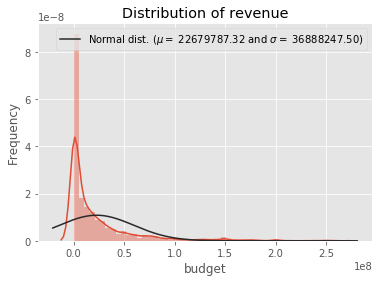

In [0]:
visualize_distribution(test.budget)

In [0]:
##Log transformation of Popularity, Budget and Revenue
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])


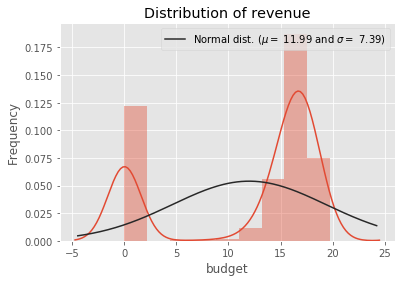

In [0]:
visualize_distribution(train.budget)

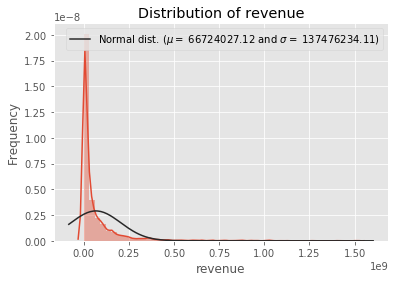

In [0]:
visualize_distribution(train.revenue)

### Features from cast and crew

In [0]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
train.loc[train["crew"].notnull(),"crew"]=train.loc[train["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))


In [0]:
test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
test.loc[test["crew"].notnull(),"crew"]=test.loc[test["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

In [0]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6])
test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6])

In [0]:
train.loc[train["cast"].notnull(),"cast"][0]

['Rob Corddry',
 'Craig Robinson',
 'Clark Duke',
 'Adam Scott',
 'Chevy Chase',
 'Gillian Jacobs']

### Director, Producer, Executive Producer

In [0]:
def get_DirProdExP(df):
    df["Director"]=[[] for i in range(df.shape[0])]
    df["Producer"]=[[] for i in range(df.shape[0])]
    df["Executive Producer"]=[[] for i in range(df.shape[0])]

    df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

    df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

    df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])
    
    return df


In [0]:
train = get_DirProdExP(train)
test = get_DirProdExP(test)

In [0]:
train.head(3)


,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Director,Producer,Executive Producer
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,"[{'id': 35, 'name': 'Comedy'}]",NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]"
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz]
2,3,NaN,15.009433,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette..."


## Quantitative Features

In [0]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3000.000000,3.000000e+03,2998.000000,3.000000e+03
mean,1500.500000,11.985069,1.975396e+00,108.242161,6.672403e+07
std,866.169729,7.394925,7.416869e-01,21.020877,1.374992e+08
min,1.000000,0.000000,9.999995e-07,11.000000,1.000000e+00
25%,750.750000,0.000000,1.613042e+00,94.000000,2.447642e+06
50%,1500.500000,15.894952,2.125233e+00,104.000000,1.692863e+07
75%,2250.250000,17.216708,2.475780e+00,118.000000,6.877599e+07
max,3000.000000,19.755682,5.688117e+00,338.000000,1.519558e+09


In [0]:
print ('budget: ' + str(sum(train['budget'].isna())) + ', popularity: ' + str(sum(train['popularity'].isna())) + 
      ', runtime: ' + str(sum(train['runtime'].isna())) + ', revenue: ' + str(sum(train['revenue'].isna())))

budget: 0, popularity: 0, runtime: 2, revenue: 0


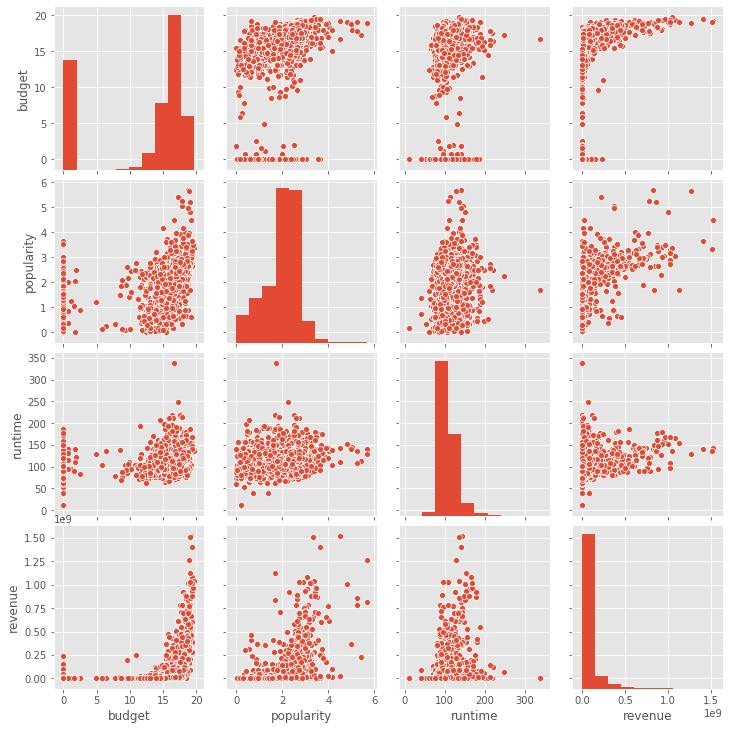

In [0]:
f = ['budget', 'popularity', 'runtime', 'revenue']
sns.pairplot(train[f].dropna())

### Language
The spoken languages are contained in a list of dictionaries, represented by a string, let's symplify it.


In [0]:
print("raw format:", train['spoken_languages'].iloc[0])

raw format: [{'iso_639_1': 'en', 'name': 'English'}]


In [0]:
train['spoken_languages'] = train['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test['spoken_languages'] = test['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

train.head().spoken_languages

0        [en]
1        [en]
2        [en]
3    [en, hi]
4        [ko]
Name: spoken_languages, dtype: object

In [0]:
#Now we can create 2 additional features: the number of spoken languages, and wheter the english belongs to them.
train['nb_spoken_languages'] = train.spoken_languages.apply(len)
test['nb_spoken_languages'] = test.spoken_languages.apply(len)

#train['english_spoken'] = train.spoken_languages.apply(lambda x: 'en' in x)
#test['english_spoken'] = test.spoken_languages.apply(lambda x: 'en' in x)

train['english_spoken'] = train.spoken_languages.apply(lambda x: 1 if 'en' in x else 0)
test['english_spoken'] = test.spoken_languages.apply(lambda x: 1 if 'en' in x else 0)


In [0]:
lc = ['spoken_languages','nb_spoken_languages','english_spoken']
train[lc].head()

,spoken_languages,nb_spoken_languages,english_spoken
0,[en],1,1
1,[en],1,1
2,[en],1,1
3,"[en, hi]",2,1
4,[ko],1,0


In [0]:
train['english_spoken'].value_counts()

1    2618
0     382
Name: english_spoken, dtype: int64

### Original Language
Let's see what are the principal main original languages in both train and test data :

In [0]:
all_languages = pd.concat([train.original_language, test.original_language], axis=0).value_counts()
all_languages[all_languages > 10]

en    6351
fr     199
hi     118
ru     109
es      95
ja      90
it      56
de      49
ko      49
zh      46
cn      41
ta      31
sv      20
da      17
pt      13
ml      12
nl      11
Name: original_language, dtype: int64

In [0]:
# Here are the main languages
main_languages = list(all_languages[all_languages>20].index)
# Let's categorize them, and add a 'other' catergorie
dict_language = dict(zip(main_languages, range(1, len(main_languages)+1)))
dict_language['other'] = 0
#keep only the languages that are on main_languages
train.original_language = train.original_language.apply(lambda x: x if x in main_languages else 'other')
test.original_language = test.original_language.apply(lambda x: x if x in main_languages else 'other')

#put languages to numeric according to the indexes of the dictionary
train['language'] = train.original_language.apply(lambda x: dict_language[x])
test['language'] = test.original_language.apply(lambda x: dict_language[x])

In [0]:
dict_language

{'cn': 11,
 'de': 8,
 'en': 1,
 'es': 5,
 'fr': 2,
 'hi': 3,
 'it': 7,
 'ja': 6,
 'ko': 9,
 'other': 0,
 'ru': 4,
 'ta': 12,
 'zh': 10}

### Movie Genre
Let's look at the different genres associated with the movies.

In [0]:
train.genres = train.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.genres = test.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train.genres.head()


0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

<BarContainer object of 8 artists>

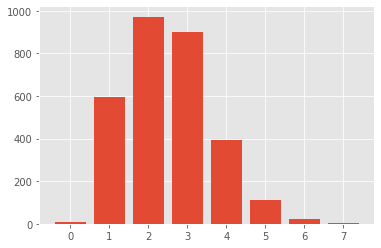

In [0]:
#Here is the distribution of the number of genres per movie. There are some films with 7 genres!
plt.bar(train.genres.apply(len).value_counts().sort_index().keys(), train.genres.apply(len).value_counts().sort_index())


In [0]:
for v in train[train.genres.apply(len)==7][['title', 'genres']].values:
    print('film:', v[0], '\ngenres:', *v[1], '\n')

film: Jimmy Neutron: Boy Genius 
genres: Action Adventure Animation Comedy Family Fantasy Science Fiction 

film: Fishtales 
genres: Fantasy Drama Comedy Science Fiction Romance Family Foreign 

film: Crossroads 
genres: Action Adventure Comedy Drama Family Music Romance 



In [0]:
train.genres.head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

In [0]:
#Frequency of all genres:
genres = Counter(itertools.chain.from_iterable(pd.concat((train.genres, test.genres), axis=0).values))
genres

Counter({'Action': 1735,
         'Adventure': 1116,
         'Animation': 382,
         'Comedy': 2605,
         'Crime': 1084,
         'Documentary': 221,
         'Drama': 3676,
         'Family': 675,
         'Fantasy': 628,
         'Foreign': 84,
         'History': 295,
         'Horror': 735,
         'Music': 267,
         'Mystery': 550,
         'Romance': 1435,
         'Science Fiction': 744,
         'TV Movie': 1,
         'Thriller': 1869,
         'War': 243,
         'Western': 117})

In [0]:
#Instead of creating 20 categorical features, one for each genre, let's reduce those categories in a smaller space thanks to SVD.

#%%time
temp_train = train[['id', 'genres']]
temp_test = test[['id', 'genres']]

for g in genres:
    temp_train[g] = temp_train.genres.apply(lambda x: 1 if g in x else 0)
    temp_test[g] = temp_test.genres.apply(lambda x: 1 if g in x else 0)
    
X_train = temp_train.drop(['genres', 'id'], axis=1).values
X_test = temp_test.drop(['genres', 'id'], axis=1).values

# Number of features we want for genres
n_comp_genres = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_genres),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

In [0]:
for i in range(n_comp_genres):
    train['genre_reduced_{}'.format(i)] = f_train[:, i]
    test['genre_reduced_{}'.format(i)] = f_test[:, i]

In [0]:
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Director,Producer,Executive Producer,nb_spoken_languages,english_spoken,language,production_countries,US,IN,KR,CA,GB,DE,FR,NZ,JP,IE,IT,BE,CN,HK,RU,ES,AU,SE,NL,DK,MX
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,[Comedy],NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]",1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[Comedy, Drama, Family, Romance]",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz],1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,NaN,15.009433,[Drama],http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,[en],Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette...",1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
my_genres = [g for g in genres if g != 'TV Movie']
my_genres


['Comedy',
 'Drama',
 'Family',
 'Romance',
 'Thriller',
 'Action',
 'Animation',
 'Adventure',
 'Horror',
 'Documentary',
 'Music',
 'Crime',
 'Science Fiction',
 'Mystery',
 'Foreign',
 'Fantasy',
 'War',
 'Western',
 'History']

In [0]:
train = pd.concat([train, temp_train.iloc[:,1:]], axis=1) 
train.drop(train.columns[-1],axis=1, inplace = True)

test = pd.concat([test, temp_test.iloc[:,1:]], axis=1) 
test.drop(test.columns[-1], axis=1, inplace = True)

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,Director,Producer,Executive Producer,nb_spoken_languages,english_spoken,language,production_countries,US,IN,KR,CA,GB,DE,FR,NZ,JP,IE,IT,BE,CN,HK,RU,ES,AU,SE,NL,DK,MX
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,[Comedy],NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,[en],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]",1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[Comedy, Drama, Family, Romance]",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,[en],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz],1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,NaN,15.009433,[Drama],http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,[en],Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette...",1,1,1,[US],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,NaN,13.997833,"[Thriller, Drama]",http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[en, hi]",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000.0,[Sujoy Ghosh],[Sujoy Ghosh],[],2,1,3,[IN],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,NaN,0.000000,"[Action, Thriller]",NaN,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,[ko],Released,NaN,Marine Boy,NaN,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970.0,[Jong-seok Yoon],[],[],1,0,9,[KR],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Keywords

In [0]:
train.Keywords = train.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.Keywords = test.Keywords.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))


In [0]:
train['nb_keywords'] = train.Keywords.apply(len)
test['nb_keywords'] = test.Keywords.apply(len)

In [0]:
train.nb_keywords.head()

0     4
1     4
2    12
3     7
4     0
Name: nb_keywords, dtype: int64

### Production_companies¶

In [0]:
train.production_companies = train.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_companies = test.production_companies.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))


In [0]:
train.production_companies.head()

0    [Paramount Pictures, United Artists, Metro-Gol...
1                               [Walt Disney Pictures]
2    [Bold Films, Blumhouse Productions, Right of W...
3                                                   []
4                                                   []
Name: production_companies, dtype: object

In [0]:
production_companies = Counter(itertools.chain.from_iterable(pd.concat((train.production_companies, test.production_companies), axis=0).values))
print("Number of different production companies:", len(production_companies))


Number of different production companies: 7087


In [0]:
train['nb_production_companies'] = train.production_companies.apply(len)
test['nb_production_companies'] = test.production_companies.apply(len)


In [0]:
train.nb_production_companies.head()

0    3
1    1
2    3
3    0
4    0
Name: nb_production_companies, dtype: int64

In [0]:
print('Applying SVD on production companies to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_companies = [p for p in production_companies if production_companies[p] > 30]
train.production_companies = train.production_companies.apply(lambda l: list(map(lambda x: x if x in big_companies else 'other', l)))

temp_train = train[['id', 'production_companies']]
temp_test = test[['id', 'production_companies']]

for p in big_companies + ['other']:
    temp_train[p] = temp_train.production_companies.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_companies.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_companies', 'id'], axis=1).values
X_test = temp_test.drop(['production_companies', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_companies = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_companies),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_companies):
    train['production_companies_reduced_{}'.format(i)] = f_train[:, i]
    test['production_companies_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production companies to create reduced features


In [0]:
train[['production_companies_reduced_0', 'production_companies_reduced_1', 'production_companies_reduced_2']].head(3)


,production_companies_reduced_0,production_companies_reduced_1,production_companies_reduced_2
0,0.284985,-0.272188,-0.919074
1,0.617273,-0.312972,-0.721819
2,0.998025,-0.041265,-0.047374


### Production countries

In [0]:
train.production_countries = train.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_countries = test.production_countries.apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))


ValueError: ignored

In [0]:
production_countries = Counter(itertools.chain.from_iterable(pd.concat((train.production_countries, test.production_countries), axis=0).values))
print("Number of different production countries:", len(production_countries))


Number of different production countries: 98


In [0]:
print('Applying SVD on production countries to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_countries = [p for p in production_countries if production_countries[p] > 30]
train.production_countries = train.production_countries.apply(lambda l: list(map(lambda x: x if x in big_countries else 'other', l)))

temp_train = train[['id', 'production_countries']]
temp_test = test[['id', 'production_countries']]

for p in big_countries + ['other']:
    temp_train[p] = temp_train.production_countries.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_countries.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_countries', 'id'], axis=1).values
X_test = temp_test.drop(['production_countries', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_countries = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_countries),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_countries):
    train['production_countries_reduced_{}'.format(i)] = f_train[:, i]
    test['production_countries_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production countries to create reduced features


In [0]:
train[['production_countries_reduced_0', 'production_countries_reduced_1', 'production_countries_reduced_2']].head(3)

,production_countries_reduced_0,production_countries_reduced_1,production_countries_reduced_2
0,0.990581,-0.1362,-0.014073
1,0.990581,-0.1362,-0.014073
2,0.990581,-0.1362,-0.014073


### Release Data

In [0]:
test.loc[test.release_date.isna(), 'release_date'] = '05/01/00'

In [0]:
#Train
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
train['Year'] = train.release_date.dt.year
train['Month'] = train.release_date.dt.month
train['Day'] = train.release_date.dt.day
train['dayofweek'] = train.release_date.dt.dayofweek 
train['quarter'] = train.release_date.dt.quarter   
#Test
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')
test['Year'] = test.release_date.dt.year
test['Month'] = test.release_date.dt.month
test['Day'] = test.release_date.dt.day
test['dayofweek'] = test.release_date.dt.dayofweek 
test['quarter'] = test.release_date.dt.quarter  

In [0]:
#Dummy Month
dummies = pd.get_dummies(train['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(x))
dummies2 = pd.get_dummies(test['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(int(x)))
train = pd.concat([train, dummies], axis=1)
test = pd.concat([test, dummies2], axis = 1)

In [0]:
#Dummy DayofWeek
ddow = pd.get_dummies(train['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(x))
ddow2 = pd.get_dummies(test['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(int(x)))
train = pd.concat([train, ddow], axis=1)
test = pd.concat([test, ddow2], axis = 1)

In [0]:
print ('Train: ' + str(max(train.Year)) + ' Test: ' + str(max(test.Year)))


Train: 2068 Test: 2068


In [0]:
train[train.Year==2068].release_date.head()

140    2068-07-18
634    2068-02-07
647    2068-10-10
1034   2068-04-02
1187   2068-03-22
Name: release_date, dtype: datetime64[ns]

In [0]:
#Train
train.loc[train['Year'] > 2018, 'Year'] = train.loc[train['Year'] > 2018, 'Year'].apply(lambda x: x - 100)
#Test
test.loc[test['Year'] > 2018, 'Year'] = test.loc[test['Year'] > 2018, 'Year'].apply(lambda x: x - 100)

In [0]:
test.Year.describe()

count    4398.000000
mean     1999.675307
std        15.286695
min      1922.000000
25%      1992.000000
50%      2004.000000
75%      2011.000000
max      2018.000000
Name: Year, dtype: float64

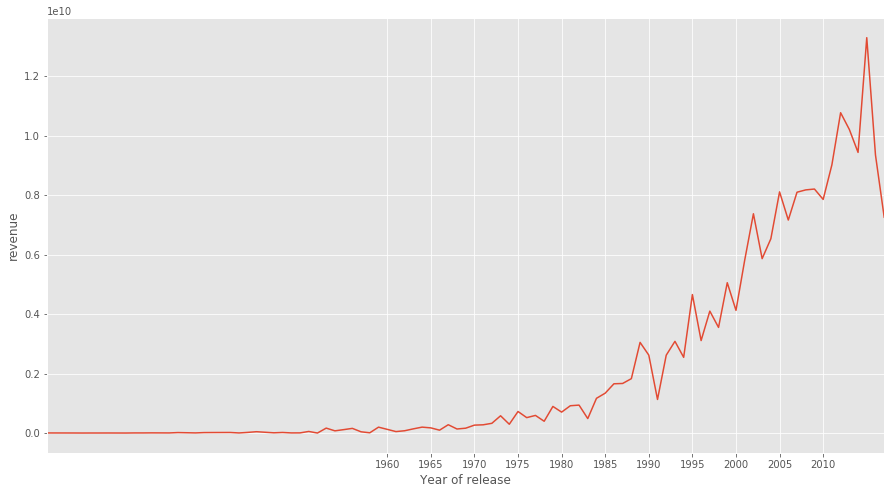

In [0]:
#Year Distribution
data_plot = train[['revenue', 'Year']]
money_Y = data_plot.groupby('Year')['revenue'].sum()

money_Y.plot(figsize=(15,8))
plt.xlabel("Year of release")
plt.ylabel("revenue")
plt.xticks(np.arange(1960,2015,5))

plt.show()


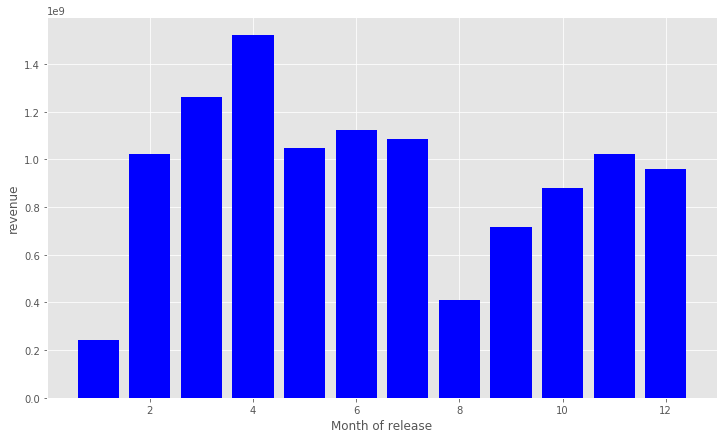

In [0]:
#Month Distribution
f,ax = plt.subplots(figsize=(12, 7))
plt.bar(train.Month, train.revenue, color = 'blue')
plt.xlabel("Month of release")
plt.ylabel("revenue")
plt.show()

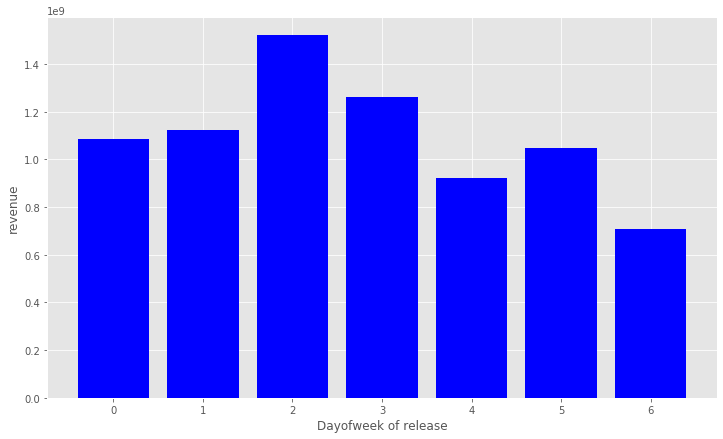

In [0]:
#Day of week Distribution
f,ax = plt.subplots(figsize=(12, 7))
plt.bar(train.dayofweek, train.revenue, color = 'blue')
plt.xlabel("Dayofweek of release")
plt.ylabel("revenue")
plt.show()

In [0]:
def lazzy_feat(df):
    
    df['Ratiobudgetbypopularity'] = df['budget']/df['popularity']
    df['RatiopopularitybyYear'] = df['popularity']/df['Year']
    df['RatoioruntimebyYear'] = df['runtime']/df['Year']
    
    
    df['budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['budget_Year_ratio'] = df['budget']/df['Year']
    
    return df

In [0]:
train = lazzy_feat(train)
test = lazzy_feat(test)

In [0]:
test['homepage'].isna()

0       False
1        True
2        True
3       False
4        True
        ...  
4393     True
4394     True
4395     True
4396     True
4397     True
Name: homepage, Length: 4398, dtype: bool

### Features from NAs Has Homepage

In [0]:
train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)
train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)

In [0]:
test['has_homepage'] = np.where(test['homepage'].isna(), 0, 1)
test ['has_collection'] = np.where(test['belongs_to_collection'].isna(), 0, 1)

In [0]:
train['has_tagline'] = np.where (train['tagline'].isna(), 0, 1)
test['has_tagline'] = np.where (test['tagline'].isna(), 0, 1)

In [0]:
ls = ['title','original_title']
train[ls].head()

,title,original_title
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement
2,Whiplash,Whiplash
3,Kahaani,Kahaani
4,Marine Boy,마린보이


In [0]:
train['title_different'] = np.where(train['original_title'] == train['title'], 0, 1)
test['title_different'] = np.where(test['original_title'] == test['title'], 0, 1)

train['isReleased'] = np.where(train['status'] != 'Released', 0, 1)
test['isReleased'] = np.where(test['status'] != 'Released', 0, 1)

In [0]:
print(train.shape)
print(test.shape)

(3000, 90)
(4398, 89)


In [0]:
train.cast.head(3)

0    [Rob Corddry, Craig Robinson, Clark Duke, Adam...
1    [Anne Hathaway, Julie Andrews, H√©ctor Elizond...
2    [Miles Teller, J.K. Simmons, Melissa Benoist, ...
Name: cast, dtype: object

In [0]:
feat_train = train.copy()
feat_test = test.copy()

print(feat_train.shape)
print(feat_test.shape)

(3000, 90)
(4398, 89)


In [0]:
lis = ['id','budget','genres','popularity','production_companies','production_countries','runtime','spoken_languages','tagline'
,'title','Keywords','cast','revenue','Director','Producer','Executive Producer','nb_spoken_languages','english_spoken','nb_production_companies',
'Year','Month','Day','dayofweek','quarter','Ratiobudgetbypopularity','RatiopopularitybyYear','RatoioruntimebyYear','budget_runtime_ratio',
'budget_Year_ratio','has_homepage','has_collection','has_tagline','title_different','isReleased']
len(lis)

34

In [0]:
feat_tran = pd.DataFrame()

In [0]:
feat_tran = train[lis]
feat_tran.head()

,id,budget,genres,genres,popularity,production_companies,production_countries,runtime,spoken_languages,tagline,title,Keywords,cast,revenue,Director,Producer,Executive Producer,nb_spoken_languages,english_spoken,nb_production_companies,Year,Month,Day,dayofweek,quarter,Ratiobudgetbypopularity,RatiopopularitybyYear,RatoioruntimebyYear,budget_runtime_ratio,budget_Year_ratio,has_homepage,has_collection,has_tagline,title_different,isReleased
0,1,16.454568,[Comedy],[Comedy],2.024905,"[Paramount Pictures, United Artists, Metro-Gol...",[US],93.0,[en],The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...",12314651.0,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]",1,1,3,2015,2,20,4,1,8.126093,0.001005,0.046154,0.176931,0.008166,0,1,1,0,1
1,2,17.504390,"[Comedy, Drama, Family, Romance]","[Comedy, Drama, Family, Romance]",2.224504,[Walt Disney Pictures],[US],113.0,[en],It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",95149435.0,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz],1,1,1,2004,8,6,4,3,7.868895,0.001110,0.056387,0.154906,0.008735,0,1,1,0,1
2,3,15.009433,[Drama],[Drama],4.178992,"[other, Blumhouse Productions, other]",[US],105.0,[en],The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",13092000.0,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette...",1,1,3,2014,10,10,4,4,3.591640,0.002075,0.052135,0.142947,0.007453,1,0,1,0,1
3,4,13.997833,"[Thriller, Drama]","[Thriller, Drama]",1.429099,[],[IN],122.0,"[en, hi]",NaN,Kahaani,"[mystery, bollywood, police corruption, crime,...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...",16000000.0,[Sujoy Ghosh],[Sujoy Ghosh],[],2,1,0,2012,3,9,4,1,9.794866,0.000710,0.060636,0.114736,0.006957,1,0,0,0,1
4,5,0.000000,"[Action, Thriller]","[Action, Thriller]",0.764570,[],[KR],118.0,[ko],NaN,Marine Boy,[],"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...",3923970.0,[Jong-seok Yoon],[],[],1,0,0,2009,2,5,3,1,0.000000,0.000381,0.058736,0.000000,0.000000,0,0,0,1,1


In [0]:
train.Month2.head()

0    1
1    0
2    0
3    0
4    1
Name: Month2, dtype: uint8

## Modeling

In [0]:
features = ['budget', 
            'popularity', 
            'runtime', 
            'nb_spoken_languages', 
            'nb_production_companies',
            'english_spoken', 
            'language',
            'has_homepage', 'has_collection', 'isReleased', 'has_tagline', 'title_different',
            'Day',
            'quarter', 'Year',
            'nb_keywords', 
            'Month2', 'Month3',  'Month4', 'Month5',  'Month6', 'Month7',
            'Ratiobudgetbypopularity', 'RatiopopularitybyYear',
            'RatoioruntimebyYear', 'budget_runtime_ratio', 'budget_Year_ratio',
            'Month8', 'Month9',  'Month10', 'Month11', 'Month12']

In [0]:
features += [col for col in train.columns if 'dayofweek' in col and col != "dayofweek"]

In [0]:
features += my_genres

In [0]:
features += ['production_companies_reduced_{}'.format(i) for i in range(n_comp_production_companies)]
features += ['production_countries_reduced_{}'.format(i) for i in range(n_comp_production_countries)]
features += ['genre_reduced_{}'.format(i) for i in range(n_comp_genres)]

In [0]:
features

['budget',
 'popularity',
 'runtime',
 'nb_spoken_languages',
 'nb_production_companies',
 'english_spoken',
 'language',
 'has_homepage',
 'has_collection',
 'isReleased',
 'has_tagline',
 'title_different',
 'Day',
 'quarter',
 'Year',
 'nb_keywords',
 'Month2',
 'Month3',
 'Month4',
 'Month5',
 'Month6',
 'Month7',
 'Ratiobudgetbypopularity',
 'RatiopopularitybyYear',
 'RatoioruntimebyYear',
 'budget_runtime_ratio',
 'budget_Year_ratio',
 'Month8',
 'Month9',
 'Month10',
 'Month11',
 'Month12',
 'dayofweek1',
 'dayofweek2',
 'dayofweek3',
 'dayofweek4',
 'dayofweek5',
 'dayofweek6',
 'Comedy',
 'Drama',
 'Family',
 'Romance',
 'Thriller',
 'Action',
 'Animation',
 'Adventure',
 'Horror',
 'Documentary',
 'Music',
 'Crime',
 'Science Fiction',
 'Mystery',
 'Foreign',
 'Fantasy',
 'War',
 'Western',
 'History',
 'production_companies_reduced_0',
 'production_companies_reduced_1',
 'production_companies_reduced_2',
 'production_countries_reduced_0',
 'production_countries_reduced_1',
 

In [0]:
X = train[features]

In [0]:
X.head()

,budget,popularity,runtime,nb_spoken_languages,nb_production_companies,english_spoken,language,has_homepage,has_collection,isReleased,has_tagline,title_different,Day,quarter,Year,nb_keywords,Month2,Month3,Month4,Month5,Month6,Month7,Ratiobudgetbypopularity,RatiopopularitybyYear,RatoioruntimebyYear,budget_runtime_ratio,budget_Year_ratio,Month8,Month9,Month10,Month11,Month12,dayofweek1,dayofweek2,dayofweek3,dayofweek4,dayofweek5,dayofweek6,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,production_companies_reduced_0,production_companies_reduced_1,production_companies_reduced_2,production_countries_reduced_0,production_countries_reduced_1,production_countries_reduced_2,genre_reduced_0,genre_reduced_1,genre_reduced_2
0,16.454568,2.024905,93.0,1,3,1,1,0,1,1,1,0,20,1,2015,4,1,0,0,0,0,0,8.126093,0.001005,0.046154,0.176931,0.008166,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283948,-0.269456,-0.920199,0.990581,-0.136200,-0.014073,0.417619,-0.648865,0.636057
1,17.504390,2.224504,113.0,1,1,1,1,0,1,1,1,0,6,3,2004,4,0,0,0,0,0,0,7.868895,0.001110,0.056387,0.154906,0.008735,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.617712,-0.313699,-0.721128,0.990581,-0.136200,-0.014073,0.771957,-0.633633,0.050910
2,15.009433,4.178992,105.0,1,3,1,1,1,0,1,1,0,10,4,2014,12,0,0,0,0,0,0,3.591640,0.002075,0.052135,0.142947,0.007453,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.998022,-0.041270,-0.047415,0.990581,-0.136200,-0.014073,0.753463,-0.151677,-0.639755
3,13.997833,1.429099,122.0,2,0,1,3,1,0,1,0,0,9,1,2012,7,0,1,0,0,0,0,9.794866,0.000710,0.060636,0.114736,0.006957,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.000002,-0.792483,0.609894,0.123704,0.869600,0.478010,0.837641,0.319139,-0.443292
4,0.000000,0.764570,118.0,1,0,0,9,0,0,1,0,1,5,1,2009,0,1,0,0,0,0,0,0.000000,0.000381,0.058736,0.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000003,0.688128,-0.725589,0.158864,0.153585,0.975281,0.529907,0.766823,0.362190


In [0]:
X['revenue'] = train.revenue

In [0]:
X.columns

Index(['budget', 'popularity', 'runtime', 'nb_spoken_languages',
       'nb_production_companies', 'english_spoken', 'language', 'has_homepage',
       'has_collection', 'isReleased', 'has_tagline', 'title_different', 'Day',
       'quarter', 'Year', 'nb_keywords', 'Month2', 'Month3', 'Month4',
       'Month5', 'Month6', 'Month7', 'Ratiobudgetbypopularity',
       'RatiopopularitybyYear', 'RatoioruntimebyYear', 'budget_runtime_ratio',
       'budget_Year_ratio', 'Month8', 'Month9', 'Month10', 'Month11',
       'Month12', 'dayofweek1', 'dayofweek2', 'dayofweek3', 'dayofweek4',
       'dayofweek5', 'dayofweek6', 'Comedy', 'Drama', 'Family', 'Romance',
       'Thriller', 'Action', 'Animation', 'Adventure', 'Horror', 'Documentary',
       'Music', 'Crime', 'Science Fiction', 'Mystery', 'Foreign', 'Fantasy',
       'War', 'Western', 'History', 'production_companies_reduced_0',
       'production_companies_reduced_1', 'production_companies_reduced_2',
       'production_countries_reduced_0',

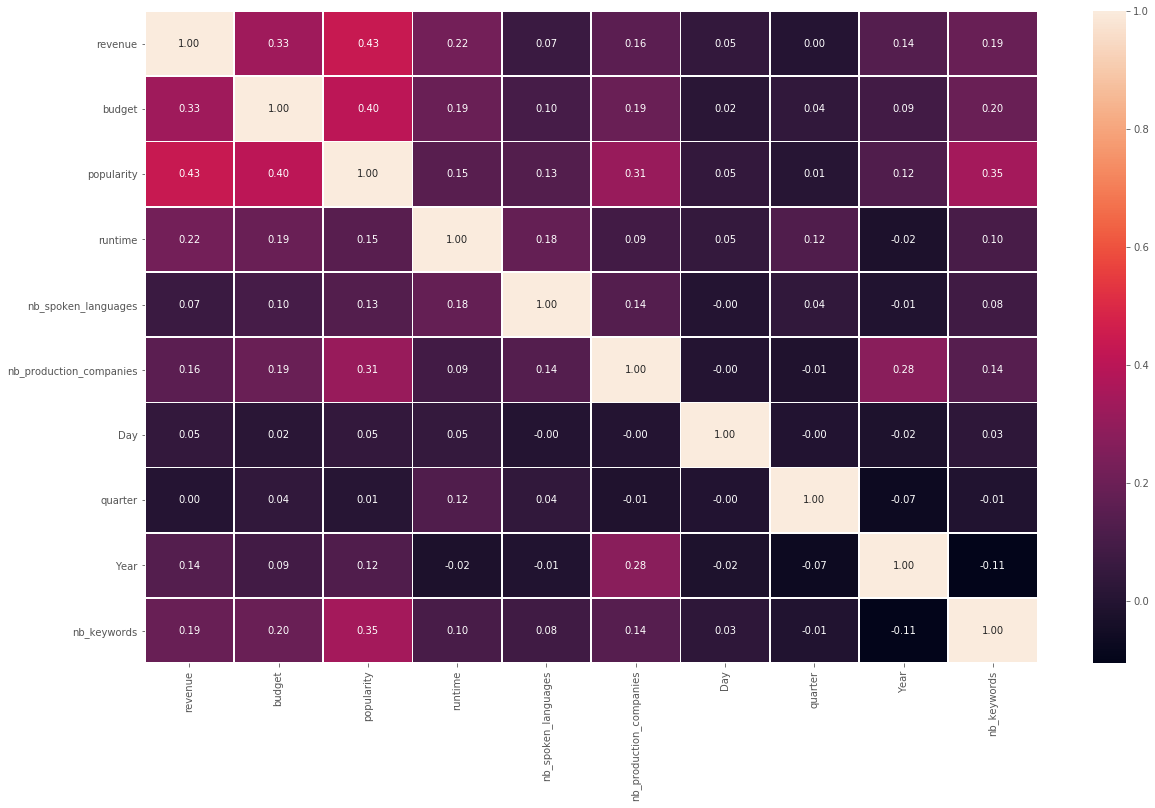

In [0]:
#Heat Correlation Matrix
cor_features = X[['revenue', 'budget',  'popularity', 'runtime', 'nb_spoken_languages', 'nb_production_companies',
            'Day', 'quarter', 'Year','nb_keywords' ]]
f,ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cor_features.corr(), annot=True, linewidths=.7, fmt= '.2f',ax=ax)
plt.show()

In [0]:
X = X.drop(['revenue'], axis = 1)

In [0]:
y = train.revenue.apply(np.log1p)

In [0]:
print(X.shape)
print(y.shape)

(3000, 66)
(3000,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 66)
(600, 66)
(2400,)
(600,)



### XGB Model

In [0]:
params = {'objective': 'reg:linear', 
          'eta': 0.01, 
          'max_depth': 6, 
          'min_child_weight': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'colsample_bylevel': 0.50, 
          'gamma': 1.45, 
          'eval_metric': 'rmse', 
          'seed': 12, 
          'silent': True    
}
# create dataset for xgboost
xgb_data = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
print('Starting training...')
# train
xgb_model = xgb.train(params, 
                  xgb.DMatrix(X_train, y_train),
                  5000,  
                  xgb_data, 
                  verbose_eval=200,
                  early_stopping_rounds=200)

Starting training...
[0]	train-rmse:15.6908	valid-rmse:15.3787
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[200]	train-rmse:2.67039	valid-rmse:2.85038
[400]	train-rmse:1.35662	valid-rmse:2.01133
[600]	train-rmse:1.16728	valid-rmse:1.99395
[800]	train-rmse:1.04829	valid-rmse:1.99197
[1000]	train-rmse:0.951043	valid-rmse:1.99055
[1200]	train-rmse:0.865044	valid-rmse:1.98697
[1400]	train-rmse:0.792716	valid-rmse:1.98736
Stopping. Best iteration:
[1207]	train-rmse:0.861836	valid-rmse:1.98653



In [0]:
xgb_validation_pred = xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit)

In [0]:
print(xgb_validation_pred.shape)
print(y_test.shape)

(600,)
(600,)


In [0]:
print(xgb_validation_pred[0:10])
print(y_test[0:10].values)

[18.062471  14.25312   17.021425  15.098437  13.558346  17.038301
 16.693783  13.766755  13.6630745 18.307423 ]
[18.80649003 12.88917959 17.02609248 15.66350432 13.64910762 17.04680448
 16.9476033  12.42276745 16.93923328 16.66147061]


In [0]:
xgb_model_full = xgb.XGBRegressor(objective  = 'reg:linear', 
          eta = 0.01, 
          max_depth = 6,
          min_child_weight = 3,
          subsample = 0.8, 
          colsample_bytree = 0.8,
          colsample_bylevel = 0.50, 
          gamma = 1.45, 
          eval_metric = 'rmse',
          seed = 12, n_estimators = 2000)
xgb_model_full.fit (X.values, y)

[13:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01,
             eval_metric='rmse', gamma=1.45, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=3, missing=None, n_estimators=2000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=12, silent=None,
             subsample=0.8, verbosity=1)

## CatBoost 

In [0]:
catmodel = catb.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.7,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=12)

ti=time.time()
catmodel.fit(X, y, 
             eval_set=(X_train, y_train), 
             verbose=500, 
             use_best_model=True)

print("Number of minutes of training of model_cal = {:.2f}".format((time.time()-ti)/60))

cat_pred_train=catmodel.predict(X)
cat_pred_train[cat_pred_train<0]=0


0:	learn: 2.9647659	test: 2.9598574	best: 2.9598574 (0)	total: 51.6ms	remaining: 8m 35s
500:	learn: 1.8349461	test: 1.8076233	best: 1.8076233 (500)	total: 2.01s	remaining: 38.2s
1000:	learn: 1.6488759	test: 1.6128016	best: 1.6128016 (1000)	total: 3.99s	remaining: 35.9s
1500:	learn: 1.5372163	test: 1.4996721	best: 1.4996721 (1500)	total: 5.9s	remaining: 33.4s
2000:	learn: 1.4489521	test: 1.4132405	best: 1.4132405 (2000)	total: 7.77s	remaining: 31.1s
2500:	learn: 1.3759111	test: 1.3411343	best: 1.3411343 (2500)	total: 9.61s	remaining: 28.8s
3000:	learn: 1.3069344	test: 1.2733172	best: 1.2733172 (3000)	total: 11.5s	remaining: 26.8s
3500:	learn: 1.2454915	test: 1.2141794	best: 1.2141794 (3500)	total: 13.4s	remaining: 24.9s
4000:	learn: 1.1890903	test: 1.1604068	best: 1.1604068 (4000)	total: 15.3s	remaining: 23s
4500:	learn: 1.1334286	test: 1.1074730	best: 1.1074730 (4500)	total: 17.2s	remaining: 21.1s
5000:	learn: 1.0829197	test: 1.0590229	best: 1.0590229 (5000)	total: 19.2s	remaining: 19.

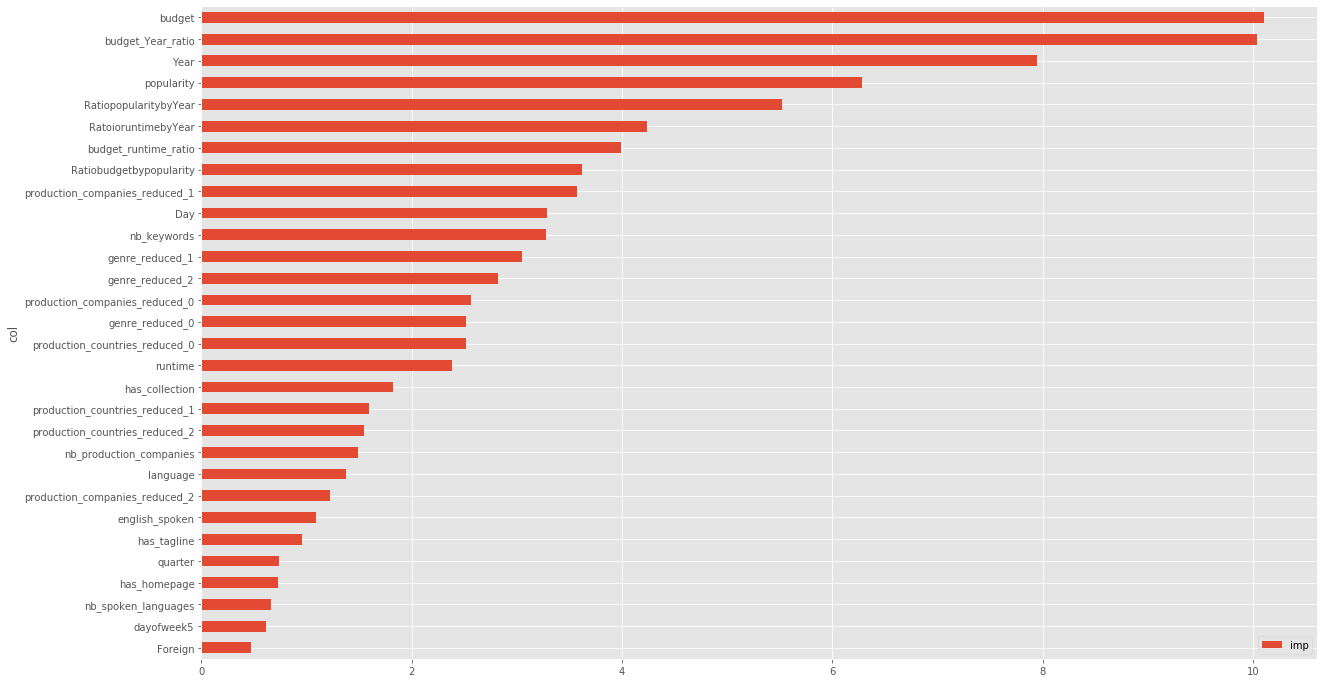

In [0]:
# Feature Importance CATB
fea_imp = pd.DataFrame({'imp': catmodel.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 12))
plt.savefig('catboost_feature_importance.png')   


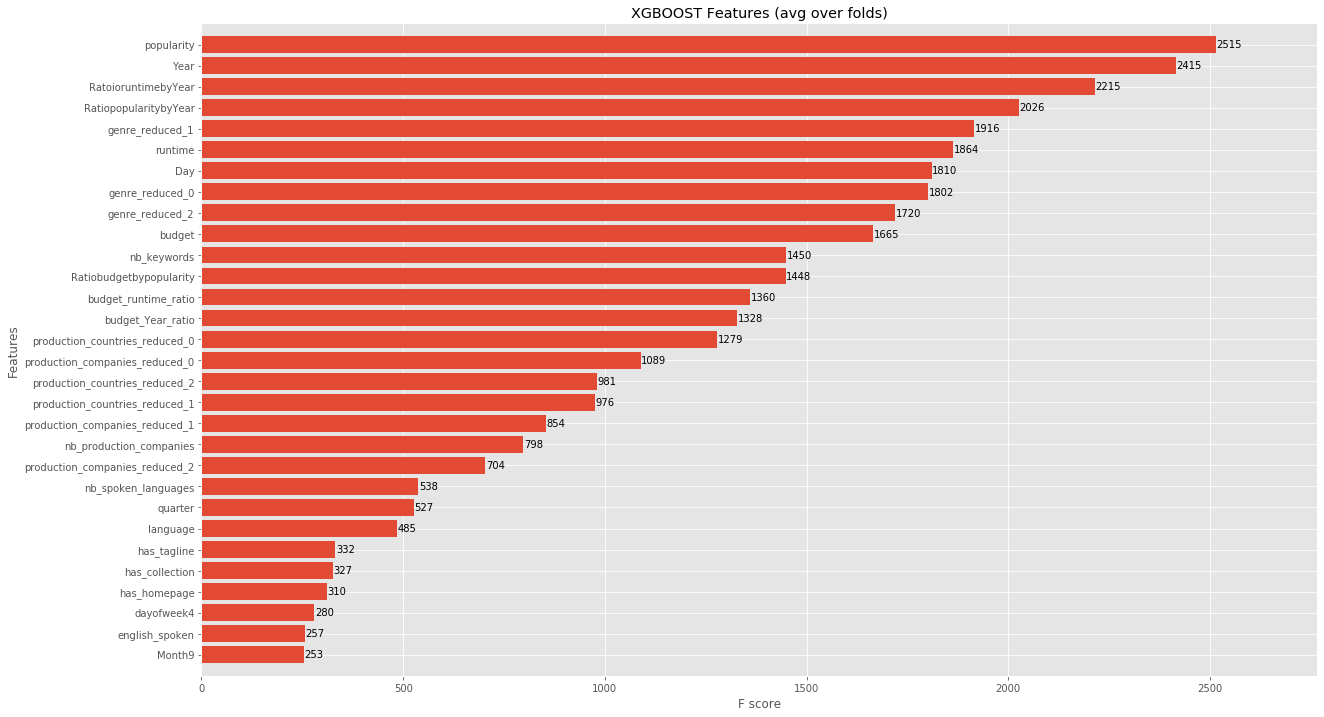

In [0]:
fig, ax = plt.subplots(figsize=(20,12))
xgb.plot_importance(xgb_model, max_num_features=30, height = 0.8, ax = ax)
plt.title('XGBOOST Features (avg over folds)')
plt.show()


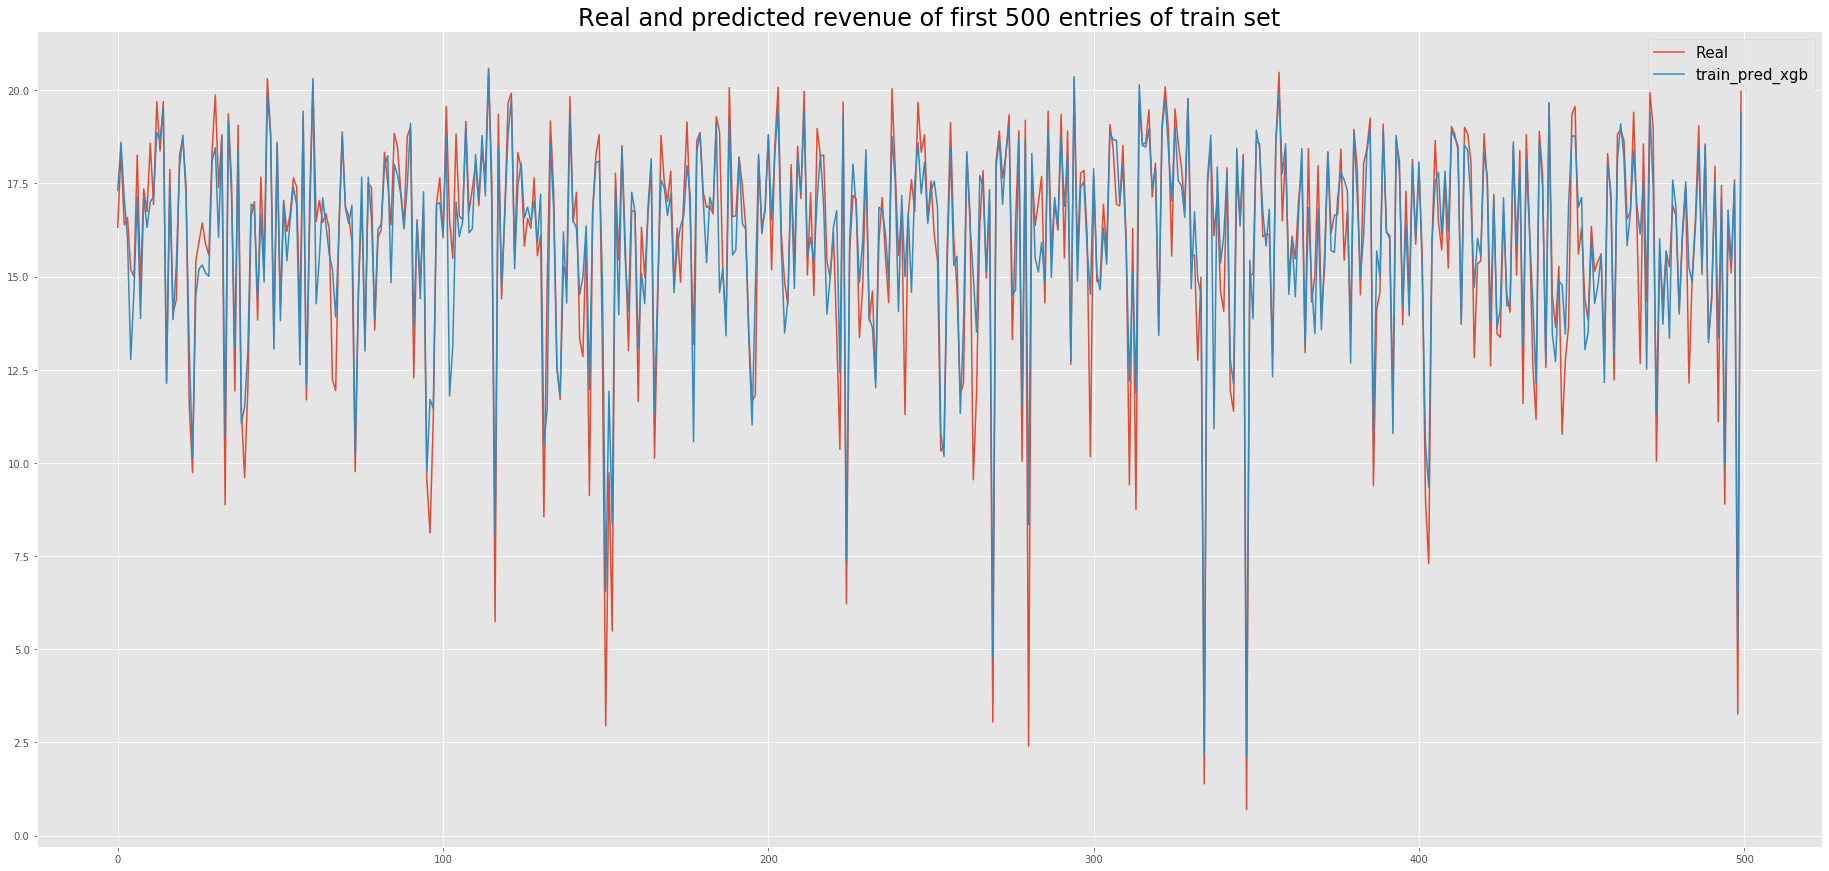

In [0]:
train_pred = xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit)
plt.figure(figsize=(32,15))
plt.plot(y[:500],label="Real")
plt.plot(train_pred[:500],label="train_pred_xgb")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()


In [0]:
plt.figure(figsize=(32,15))
plt.plot(y[:500],label="Real")
plt.plot(cat_pred_train[:500],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()


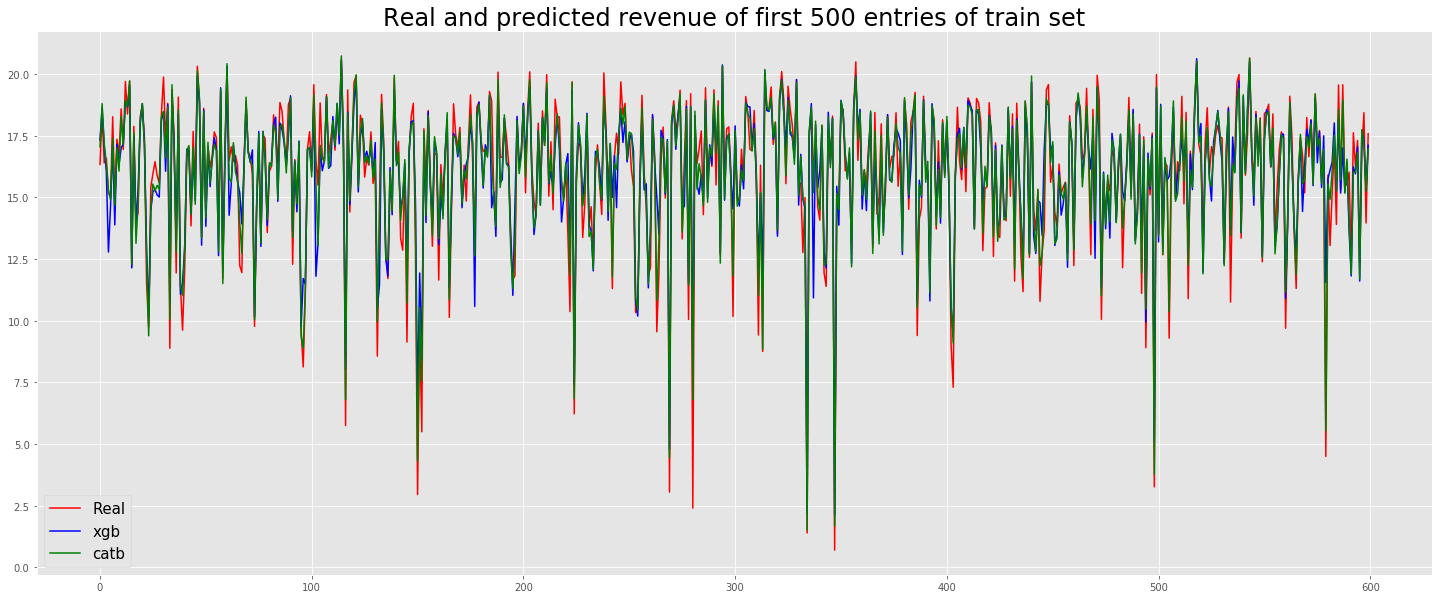

In [0]:
plt.figure(figsize=(25,10))
plt.plot(y[:600],label="Real", color = "red")
plt.plot(xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit)[:600],label="xgb", color = "blue")
plt.plot(cat_pred_train[:600],label="catb", color = "green")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

In [0]:
X_test = test[features]
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test.id, 'revenue': xgb_pred}).to_csv('xgbsubmission.csv', index=False)


In [0]:
cat_pred_train.shape

(3000,)

In [0]:
X.shape

(3000, 66)

In [0]:
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test.id, 'revenue_actual':np.expm1(y_test), 'revenue_xgb': xgb_pred}).to_csv('xgbsubmission.csv', index=False)


In [0]:
y_test.head()

248     18.806490
2524    12.889180
760     17.026092
2422    15.663504
1197    13.649108
Name: revenue, dtype: float64

In [0]:
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
result_df = pd.DataFrame({'id': y_test.index, 'revenue_actual':np.expm1(y_test.values), 'revenue_xgb': xgb_pred})

In [0]:
y_test.shape

(600,)

In [0]:
result_df.head()

,id,revenue_actual,revenue_xgb
0,248,147080413.0,6.989267e+07
1,2524,396003.0,1.549000e+06
2,760,24793509.0,2.467806e+07
3,2422,6347072.0,3.607180e+06
4,1197,846704.0,7.732398e+05


In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
rmse = sqrt(mean_squared_error(result_df['revenue_actual'], result_df['revenue_xgb']))
print("RMSE on validation(0.2) data is: " + str(rmse))


RMSE on validation(0.2) data is: 61689909.867332645


In [0]:
xgb_pred = xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit)
result_df_log = pd.DataFrame({'id': y_test.index, 'revenue_actual':y_test.values, 'revenue_xgb': xgb_pred})

In [0]:
rmse_log = sqrt(mean_squared_error(result_df_log['revenue_actual'], result_df_log['revenue_xgb']))
print("RMSE on validation(0.2) data is: " + str(rmse_log))


RMSE on validation(0.2) data is: 1.9865334051294794


In [0]:
result_df_log.to_csv('validation_log_results.csv')

In [0]:
result_df.to_csv('validation_results.csv')

In [0]:
X_test = test[features]
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test.id, 'revenue': xgb_pred}).to_csv('xgbsubmission.csv', index=False)


In [0]:
xgb_pred.shape

(4398,)

In [0]:
xgb_pred_f = np.expm1(xgb_model_full.predict(X_test.values))
pd.DataFrame({'id': test.id, 'revenue': xgb_pred_f}).to_csv('xgbfullsubmission.csv', index=False)
xgb_pred_f[0]

24336556.0

In [0]:
X_test = test[features]
catb_pred = np.expm1(catmodel.predict(X_test.values))
pd.DataFrame({'id': test.id, 'revenue': catb_pred}).to_csv('catbsubmission.csv', index=False)


In [0]:
ens_pred = 0.3*xgb_pred_f + 0.7*catb_pred
pd.DataFrame({'id': test.id, 'revenue': ens_pred}).to_csv('enssubmission.csv', index=False)


In [0]:
train.head()

,id,belongs_to_collection,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000.0,"[{'id': 35, 'name': 'Comedy'}]",en,"When Lou, who has become the ""father of the In...",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0
2,3,NaN,3300000.0,"[{'id': 18, 'name': 'Drama'}]",en,"Under the direction of a ruthless instructor, ...",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0
3,4,NaN,1200000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000.0
4,5,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,Marine Boy is the story of a former national s...,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970.0


In [0]:
train_a = pd.read_csv('train.csv')
test_a = pd.read_csv('test.csv')

In [0]:
movies = {}
import json, requests
baseurl = "http://omdbapi.com/?apikey=3ba8ecf1&i=" #only submitting the title parameter
for line in train_a.imdb_id.tolist():
  movieTitle = line.strip("\n") # get rid of newline characters
  #print(baseurl + movieTitle)
  response = requests.get(baseurl + movieTitle)
  if response.status_code == 200:
    movies[movieTitle] = json.loads(response.text)
  else:
    print(baseurl + movieTitle)
    raise ValueError("Bad request!")
    print(baseurl + movieTitle)
#print movies['scream']